# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [2]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []
        
        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
    
    def get_OneHot_by_token(self, token):
        vector = [0]*self.num_tokens()
        vector[self.index_by_token[token]] = 1
        return torch.tensor(vector)
    
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
tense ['sex', 'onscreen', 'arguing', 'lot']
complexity ['warpath', 'devilish', 'balkans']
pyrotechnics ['jump', 'lots', 'camouflage']
vital ['fantastically', 'invest', 'sensuality']
toward ['indian', 'crossover', 'nonethnic']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [3]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts=30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        # TODO: Implement what you need for other methods!
        self.num_tokens = data.num_tokens()
        self.num_contexts = num_contexts
        self.data = data
        
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        self.dataset = []
        for i in range(self.num_contexts):
            input, targets = self.data.get_random_context()
            for target in targets:
                self.dataset.append((input, target))
    
    def __len__(self):
        '''
        Returns total number of samples
        '''
        # TODO: Return the number of samples
        return len(self.dataset)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        # TODO: Generate tuple of 2 return arguments for i-th sample    
        return self.data.get_OneHot_by_token(self.dataset[index][0]).type(torch.FloatTensor), \
    self.data.index_by_token[self.dataset[index][1]]
    
dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 15339


# Создаем модель и тренируем ее

In [53]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [54]:
x1, x2 =  nn_model.parameters()
print(x1.shape, x2.shape)

torch.Size([10, 19538]) torch.Size([19538, 10])


In [55]:
a = torch.tensor([1, 2])
b = torch.tensor([3, 4])
print(torch.cat((a.expand(1, -1),b.expand(1, -1)), dim = 0))
print(torch.cat(tuple(torch.tensor([2*i, 2*i+1]).expand(1, -1) for i in range(5)), dim = 0))

tensor([[1, 2],
        [3, 4]])
tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])


In [56]:
def get_OneHot_by_index(index, num_tokens):
    vector = [0]*num_tokens
    vector[index] = 1
    return torch.tensor(vector)

In [57]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos 
    # Hint: you can access weights as Tensors through nn.Linear class attributes
    x1, x2 = nn_model.parameters()
    num_tokens = x1.shape[1]
    num_dimensions = x1.shape[0]
    input_vectors = torch.cat(tuple(x1[:, i].expand(1, -1) for i in range(num_tokens)), dim = 0)
    output_vectors = torch.cat(tuple(x2[i, :].expand(1, -1) for i in range(num_tokens)), dim = 0)
    return input_vectors, output_vectors

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [58]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        dataset.generate_dataset() # Regenerate dataset every epoch
        num_tokens = dataset.num_tokens
        # TODO Implement training for this model
        # Note we don't have any validation set here because our purpose is the word vectors,
        # not the predictive performance of the model
        #
        # And don't forget to step the learing rate scheduler!  
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (input_vectors, targets) in enumerate(train_loader):
            predictions = model(input_vectors)
            loss_value = loss(predictions, targets)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            loss_accum += loss_value
            indices = torch.argmax(predictions, 1)
            correct_samples += torch.sum(indices == targets)
            total_samples += targets.shape[0]
        train_accuracy = float(correct_samples)/ total_samples
        ave_loss = loss_accum/(i_step + 1)
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        loss_history.append(ave_loss)
        train_history.append(train_accuracy)
        scheduler.step()
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [59]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.SGD(nn_model.parameters(), lr=25., weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 64)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Epoch 0, Average loss: 9.858433, Train accuracy: 0.001145
Epoch 1, Average loss: 9.715196, Train accuracy: 0.002020
Epoch 2, Average loss: 9.624825, Train accuracy: 0.003270
Epoch 3, Average loss: 9.559462, Train accuracy: 0.004653
Epoch 4, Average loss: 9.527572, Train accuracy: 0.005248
Epoch 5, Average loss: 9.501273, Train accuracy: 0.005782
Epoch 6, Average loss: 9.473482, Train accuracy: 0.006343
Epoch 7, Average loss: 9.449433, Train accuracy: 0.007479
Epoch 8, Average loss: 9.436385, Train accuracy: 0.006761
Epoch 9, Average loss: 9.437170, Train accuracy: 0.007045


In [60]:
optimizer = optim.SGD(nn_model.parameters(), lr=5., weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 64)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Epoch 0, Average loss: 9.066323, Train accuracy: 0.013854
Epoch 1, Average loss: 8.787152, Train accuracy: 0.017616
Epoch 2, Average loss: 8.633495, Train accuracy: 0.019100
Epoch 3, Average loss: 8.542457, Train accuracy: 0.021068
Epoch 4, Average loss: 8.461139, Train accuracy: 0.021200
Epoch 5, Average loss: 8.409104, Train accuracy: 0.022369
Epoch 6, Average loss: 8.369001, Train accuracy: 0.023238
Epoch 7, Average loss: 8.315353, Train accuracy: 0.024275
Epoch 8, Average loss: 8.290863, Train accuracy: 0.023757
Epoch 9, Average loss: 8.257461, Train accuracy: 0.024546


In [61]:
optimizer = optim.SGD(nn_model.parameters(), lr=2., weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 64)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Epoch 0, Average loss: 8.203075, Train accuracy: 0.028548
Epoch 1, Average loss: 8.155765, Train accuracy: 0.028479
Epoch 2, Average loss: 8.136610, Train accuracy: 0.029667
Epoch 3, Average loss: 8.078076, Train accuracy: 0.030837
Epoch 4, Average loss: 8.108053, Train accuracy: 0.029982
Epoch 5, Average loss: 8.079286, Train accuracy: 0.029523
Epoch 6, Average loss: 8.049243, Train accuracy: 0.031099
Epoch 7, Average loss: 8.051313, Train accuracy: 0.030894
Epoch 8, Average loss: 8.038689, Train accuracy: 0.031492
Epoch 9, Average loss: 8.021960, Train accuracy: 0.031359


In [62]:
optimizer = optim.SGD(nn_model.parameters(), lr=1., weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 64)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Epoch 0, Average loss: 8.007970, Train accuracy: 0.033106
Epoch 1, Average loss: 7.959791, Train accuracy: 0.032656
Epoch 2, Average loss: 7.944862, Train accuracy: 0.033303
Epoch 3, Average loss: 7.958835, Train accuracy: 0.032426
Epoch 4, Average loss: 7.936786, Train accuracy: 0.034360
Epoch 5, Average loss: 7.939917, Train accuracy: 0.033626
Epoch 6, Average loss: 7.935848, Train accuracy: 0.033378
Epoch 7, Average loss: 7.911690, Train accuracy: 0.034896
Epoch 8, Average loss: 7.910501, Train accuracy: 0.035359
Epoch 9, Average loss: 7.916816, Train accuracy: 0.034875


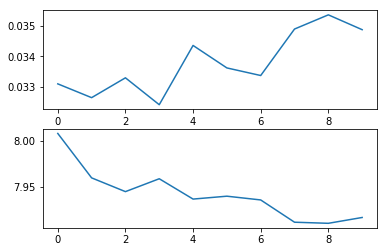

In [63]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

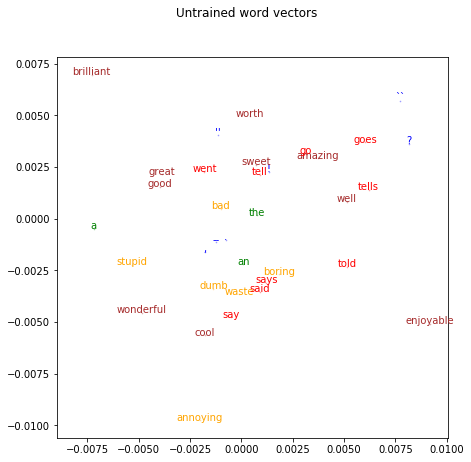

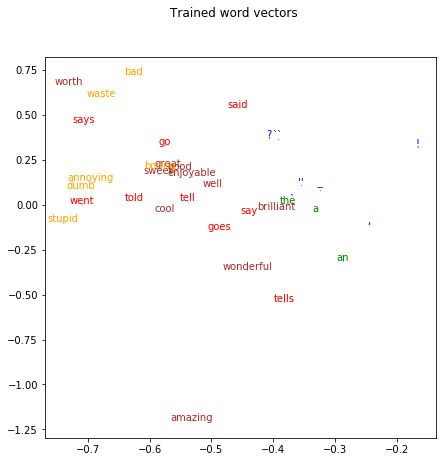

In [65]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")

In [80]:
trained_output_vectors[data.index_by_token["artificial"]]
trained_output_vectors[data.index_by_token["brain"]]

tensor([-0.0130, -0.0386, -0.0349,  0.3169, -1.5009, -0.8481,  0.9847, -1.0948,
         0.6077, -0.2082], grad_fn=<SelectBackward>)

In [77]:
def token_min_distance(trained_output_vectors, vector):
    index = np.argmax(np.array([sum((trained_output_vectors[i] - vector)**2) for i in range(len(trained_output_vectors))]))
    return data.token_by_index[index]

In [93]:
def k_neighbour_vector(trained_output_vectors, vector, k):
    return [data.token_by_index[x[1]] for x in sorted([(sum((trained_output_vectors[i] - vector)**2), i) \
            for i in range(len(trained_output_vectors))], reverse=True)[:k]]

In [82]:
def sum_words(trained_output_vectors, token1, token2):
    return token_min_distance(trained_output_vectors, \
    trained_output_vectors[data.index_by_token[token1]] + trained_output_vectors[data.index_by_token[token2]])

In [91]:
def sum_words_vector(trained_output_vectors, token1, token2):
    return trained_output_vectors[data.index_by_token[token1]] + trained_output_vectors[data.index_by_token[token2]]

In [85]:
def sub_words(trained_output_vectors, token1, token2):
    return token_min_distance(trained_output_vectors, \
    trained_output_vectors[data.index_by_token[token2]] - trained_output_vectors[data.index_by_token[token1]])

In [78]:
token_min_distance(trained_output_vectors, trained_output_vectors[data.index_by_token["artificial"]] + trained_output_vectors[data.index_by_token["human"]])

'catalog'

In [89]:
sum_words(trained_output_vectors, "apple", "dough")

'commanding'

In [98]:
k_neighbour_vector(trained_output_vectors, \
                   sum_words_vector(trained_output_vectors, "wagers", "excitement"), 10)

[',', 'the', '.', 'of', 'to', 'and', 'a', "'s", 'it', 'in']

In [104]:
k_neighbour_vector(trained_output_vectors,trained_output_vectors[data.index_by_token["coffee"]], 10)

['collage',
 'dim',
 'adoring',
 'wide-smiling',
 'echo',
 'rusi',
 'hypothesis',
 'allusions',
 'diver',
 'stare']